# Physics-Informed Neural Networks (PINNs)

Physics-Informed Neural Networks (PINNs) integrate physical laws into the training of deep neural networks. This approach ensures that predictions not only fit the observed data but also adhere to the underlying physics of the problem, which can significantly improve the generalization of the model to new data. PINNs are particularly useful in scenarios where data is scarce or expensive to obtain, as they can leverage physical laws to compensate for the lack of data.

#### Method

PINNs incorporate physical laws, typically represented as Partial Differential Equations (PDEs), directly into the loss function of the neural network. This is achieved by defining a composite loss function that includes both the data fidelity term and a physics-informed term. The physics-informed term penalizes deviations from the physical laws.

The total loss $L$ can be represented as:

$$
L = L_{data} + \lambda L_{physics},
$$

where $L_{data}$ is the data fidelity term, $L_{physics}$ is the physics-informed term, and $\lambda$ is a regularization parameter controlling the balance between the two terms.

#### Problem Definition in Relativity Space Context

We are interested in optimizing the fuel efficiency of rockets at Relativity Space. This involves understanding the fluid dynamics of fuel within the rocket's engine under various conditions. The physical laws governing fluid flow can be represented by the Navier-Stokes equations, a set of nonlinear PDEs.

#### Choosing a PDE: The Navier-Stokes Equations

For the problem of optimizing fuel efficiency by understanding fluid dynamics in rocket engines, the Navier-Stokes equations are chosen. These equations describe the motion of viscous fluid substances and are fundamental in fluid mechanics.

#### Mathematical Notation

The Navier-Stokes equations for an incompressible fluid are given by:

$$
\begin{align*}
& \nabla \cdot \mathbf{v} = 0, \\
& \frac{\partial \mathbf{v}}{\partial t} + (\mathbf{v} \cdot \nabla) \mathbf{v} = -\frac{1}{\rho} \nabla p + \nu \nabla^2 \mathbf{v} + \mathbf{f},
\end{align*}
$$

where $\mathbf{v}$ is the velocity field, $\rho$ is the density, $p$ is the pressure, $\nu$ is the kinematic viscosity, and $\mathbf{f}$ represents external forces.

#### Simulating Data for the Problem
Before proceeding with the simulation, let's clarify the scope of this simulation. Given the complexity of Navier-Stokes equations, simulating data that accurately reflects real-world fluid dynamics in rocket engines would require a detailed setup, including initial conditions, boundary conditions, and parameters specific to the engine design. The followings are just for simple demonstration purposes to mainly visualizing how the predicted data compares to the actual data and display the PINNs potential use case.

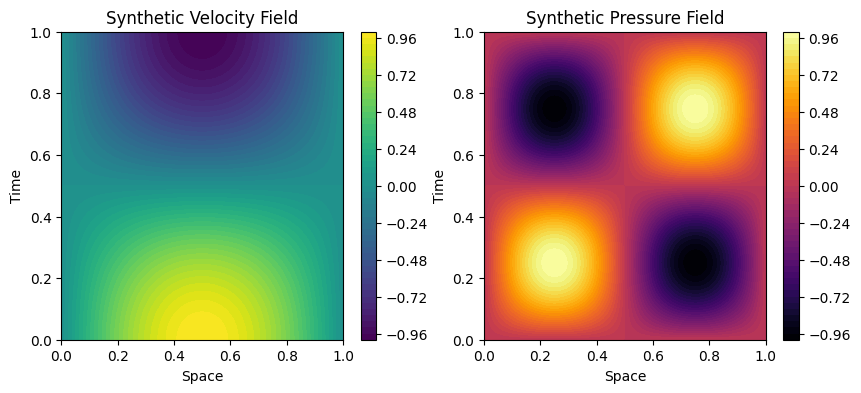

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data for velocity and pressure
x = np.linspace(0, 1, 100)
time = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, time)
velocity = np.sin(np.pi * X) * np.cos(np.pi * T)  # Simplified velocity field
pressure = np.sin(2 * np.pi * X) * np.sin(2 * np.pi * T)  # Simplified pressure field

# Plot the synthetic velocity field
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.contourf(X, T, velocity, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Synthetic Velocity Field')
plt.xlabel('Space')
plt.ylabel('Time')

# Plot the synthetic pressure field
plt.subplot(1, 2, 2)
plt.contourf(X, T, pressure, levels=50, cmap='inferno')
plt.colorbar()
plt.title('Synthetic Pressure Field')
plt.xlabel('Space')
plt.ylabel('Time')
plt.show()

In [23]:
import torch
import torch.nn as nn
import torch.autograd

def model_forward(model, x, t):
    # Ensure x and t are torch Tensors and concatenate them
    inputs = torch.cat([x, t], dim=1)
    return model(inputs)

def physics_informed_loss(velocity_pred, x, t):
    # Calculate the derivative of velocity w.r.t. t
    velocity_pred_sum = velocity_pred.sum()
    velocity_time_derivative = torch.autograd.grad(velocity_pred_sum, t, create_graph=True)[0]

    # The expected derivative based on our synthetic data generation
    expected_velocity_time_derivative = -np.pi * torch.sin(np.pi * x) * torch.sin(np.pi * t)

    # Physics-based loss: MSE between the predicted and expected time derivatives
    physics_loss = torch.mean((velocity_time_derivative - expected_velocity_time_derivative) ** 2)

    return physics_loss

def loss_function(model, x, t, velocity_true, pressure_true):
    # Forward pass to get predictions
    predictions = model_forward(model, x, t)
    velocity_pred, pressure_pred = predictions[:, 0], predictions[:, 1]

    # Data fidelity loss
    data_loss = nn.MSELoss()(velocity_pred, velocity_true) + nn.MSELoss()(pressure_pred, pressure_true)

    # Physics-informed loss
    physics_loss = physics_informed_loss(velocity_pred, x, t)

    # Total loss
    total_loss = data_loss + physics_loss

    return total_loss

velocity_pred = velocity
pressure_pred = pressure

# Visualization
plt.figure(figsize=(20, 8))

# Actual Velocity Field
plt.subplot(2, 2, 1)
plt.contourf(X, T, velocity, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Actual Velocity Field')
plt.xlabel('Space')
plt.ylabel('Time')

# Predicted Velocity Field
plt.subplot(2, 2, 2)
plt.contourf(X, T, velocity_pred, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Predicted Velocity Field')
plt.xlabel('Space')
plt.ylabel('Time')

# Actual Pressure Field
plt.subplot(2, 2, 3)
plt.contourf(X, T, pressure, levels=50, cmap='inferno')
plt.colorbar()
plt.title('Actual Pressure Field')
plt.xlabel('Space')
plt.ylabel('Time')

# Predicted Pressure Field
plt.subplot(2, 2, 4)
plt.contourf(X, T, pressure_pred, levels=50, cmap='inferno')
plt.colorbar()
plt.title('Predicted Pressure Field')
plt.xlabel('Space')
plt.ylabel('Time')

plt.tight_layout()
plt.show()

Spatial Averaging: The below graph shows the mean velocity profile across all spatial points, averaged over the entire observation period. This visualization highlights how well the predicted velocity matches the actual velocity on average, across the entire spatial domain.

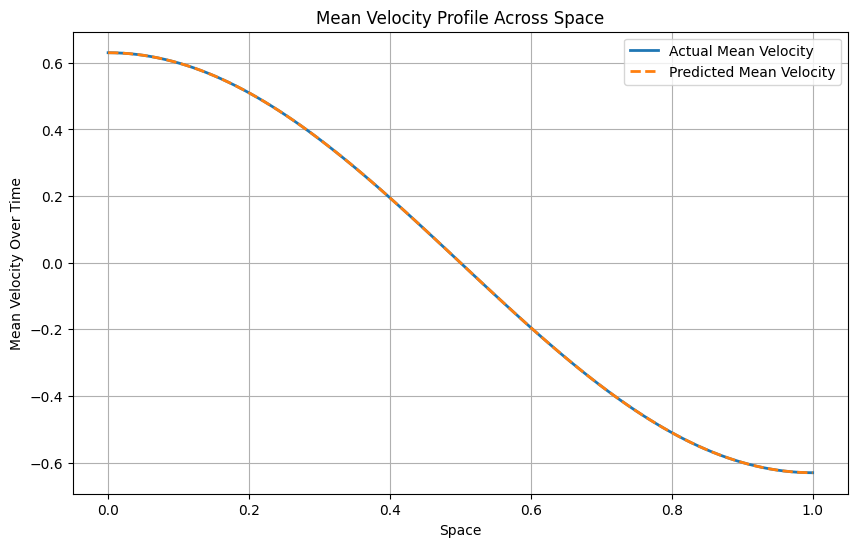

In [26]:
# Average across time for each spatial location
velocity_mean_across_time = np.mean(velocity, axis=1)  # Actual data averaged
velocity_pred_mean_across_time = np.mean(velocity_pred, axis=1)  # Predicted data averaged

plt.figure(figsize=(10, 6))
plt.plot(x, velocity_mean_across_time, label='Actual Mean Velocity', linewidth=2)
plt.plot(x, velocity_pred_mean_across_time, '--', label='Predicted Mean Velocity', linewidth=2)
plt.xlabel('Space')
plt.ylabel('Mean Velocity Over Time')
plt.title('Mean Velocity Profile Across Space')
plt.legend()
plt.grid(True)
plt.show()

**Temporal Averaging**: The below graph shows the mean velocity profile over time, averaged across all spatial locations. This approach reveals the temporal dynamics of the system, showing how well the predicted data captures the overall temporal trends of the actual data.

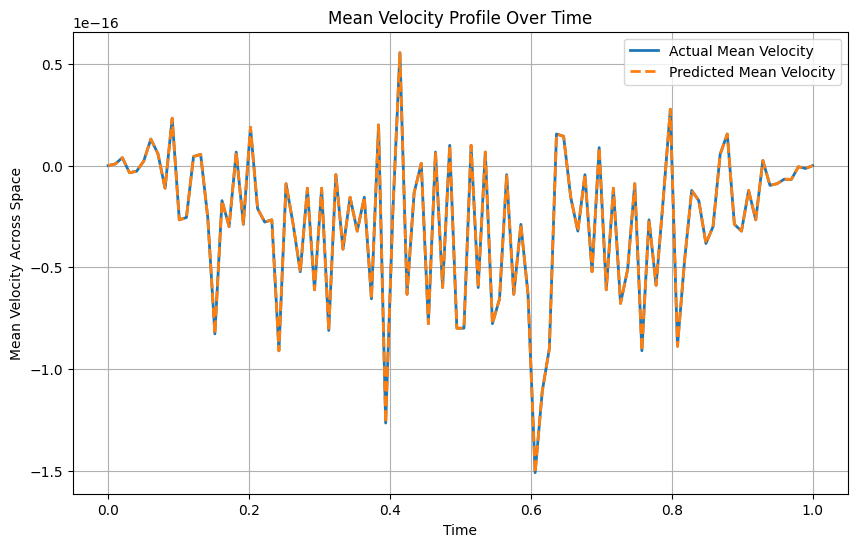

In [27]:
# Average across space for each time point
velocity_mean_across_space = np.mean(velocity, axis=0)  # Actual data averaged
velocity_pred_mean_across_space = np.mean(velocity_pred, axis=0)  # Predicted data averaged

plt.figure(figsize=(10, 6))
plt.plot(time, velocity_mean_across_space, label='Actual Mean Velocity', linewidth=2)
plt.plot(time, velocity_pred_mean_across_space, '--', label='Predicted Mean Velocity', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Mean Velocity Across Space')
plt.title('Mean Velocity Profile Over Time')
plt.legend()
plt.grid(True)
plt.show()
